# Híbrido (ARIMA + MLP) - Consumo de Energia

Estratégia: ARIMA modela componente linear; MLP modela resíduos para capturar não-linearidades.

In [30]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os, json, warnings
warnings.filterwarnings('ignore')

output_dir='../../out/household_consumption/Hibrido'
os.makedirs(output_dir, exist_ok=True)
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize']=(12,6)

In [31]:
# Dados
df = pd.read_excel('../../data/household_consumption.xlsx', sheet_name='Sheet1')
df['Date and Hour']=pd.to_datetime(df['Date and Hour'])
df=df.set_index('Date and Hour').sort_index().dropna()
y = df['Consumption']
train_size=int(len(y)*0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
print('Train/Test:', len(y_train), len(y_test))

Train/Test: 4000 1000


In [32]:
# Tuning leve do ARIMA usando AIC em pequena grade
p_values=range(0,3); d_values=range(0,2); q_values=range(0,3)
best=None; best_aic=np.inf; best_order=None
for p in p_values:
  for d in d_values:
    for q in q_values:
      try:
        model=ARIMA(y_train, order=(p,d,q))
        res=model.fit()
        if res.aic<best_aic:
          best_aic=res.aic; best=res; best_order=(p,d,q)
      except Exception as e:
        pass
print('Best ARIMA order:', best_order, 'AIC:', best_aic)
arima_fitted=best
arima_forecast = arima_fitted.forecast(steps=len(y_test))

Best ARIMA order: (2, 1, 2) AIC: 5762.083369615583


In [33]:
# Resíduos no treino e teste (one-step naive para teste: usar previsão ARIMA como baseline)
residuals_train = y_train - arima_fitted.fittedvalues
# Para alvos do MLP no teste, queremos prever o delta entre real e ARIMA
residuals_test_target = y_test - arima_forecast

# Features do MLP a partir da série e de resíduos passados
def make_features(idx, series, resids, n_lags=24):
    dfF = pd.DataFrame(index=idx)
    
    for i in range(1, n_lags+1):
        dfF[f'y_lag_{i}'] = series.shift(i).reindex(idx)
        dfF[f'resid_lag_{i}'] = resids.shift(i).reindex(idx)
    
    dfF['hour'] = idx.hour
    dfF['dow'] = idx.dayofweek
    dfF['hour_sin'] = np.sin(2*np.pi*dfF['hour']/24)
    dfF['hour_cos'] = np.cos(2*np.pi*dfF['hour']/24)
    dfF['dow_sin'] = np.sin(2*np.pi*dfF['dow']/7)
    dfF['dow_cos'] = np.cos(2*np.pi*dfF['dow']/7)
    return dfF.dropna()

# Criar features de treino
X_train = make_features(y_train.index, y_train, residuals_train, n_lags=24)
y_train_res = residuals_train.reindex(X_train.index)

# Para teste: concatenar séries completas para ter histórico
y_complete = pd.concat([y_train, y_test])
# Para resíduos de teste, usar os do treino + preencher teste com zeros (serão atualizados iterativamente na prática real)
resids_complete = pd.concat([residuals_train, pd.Series(0, index=y_test.index)])

X_test = make_features(y_test.index, y_complete, resids_complete, n_lags=24)
y_test_res = residuals_test_target.reindex(X_test.index)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Escalonamento
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

X_train shape: (3976, 54), X_test shape: (1000, 54)


In [34]:
# GridSearch para MLP nos resíduos
param_grid={
  'hidden_layer_sizes':[(64,), (128,64), (128,64,32)],
  'alpha':[0.0001,0.001,0.01],
  'activation':['relu','tanh']
}
mlp=MLPRegressor(max_iter=400, random_state=42, early_stopping=True)
tscv=TimeSeriesSplit(n_splits=4)
grid=GridSearchCV(mlp,param_grid,cv=tscv,scoring='neg_mean_squared_error',n_jobs=-1,verbose=1)
sample=min(8000, len(X_train_s))
grid.fit(X_train_s[:sample], y_train_res.iloc[:sample])
print('Best MLP:', grid.best_params_, 'CV MSE:', -grid.best_score_)
best_mlp=grid.best_estimator_
best_mlp.fit(X_train_s, y_train_res)
res_pred_test = best_mlp.predict(X_test_s)

# Combinar previsões: hibrido = ARIMA + MLP(resíduos)
y_pred_hybrid = arima_forecast.reindex(X_test.index) + pd.Series(res_pred_test, index=X_test.index)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best MLP: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64)} CV MSE: 0.2201753852406412
Best MLP: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64)} CV MSE: 0.2201753852406412


RMSE: 1.168225441975942 MAE: 1.0436976899614447 MAPE: 279.66847231911464 R2: -0.5454168053898825


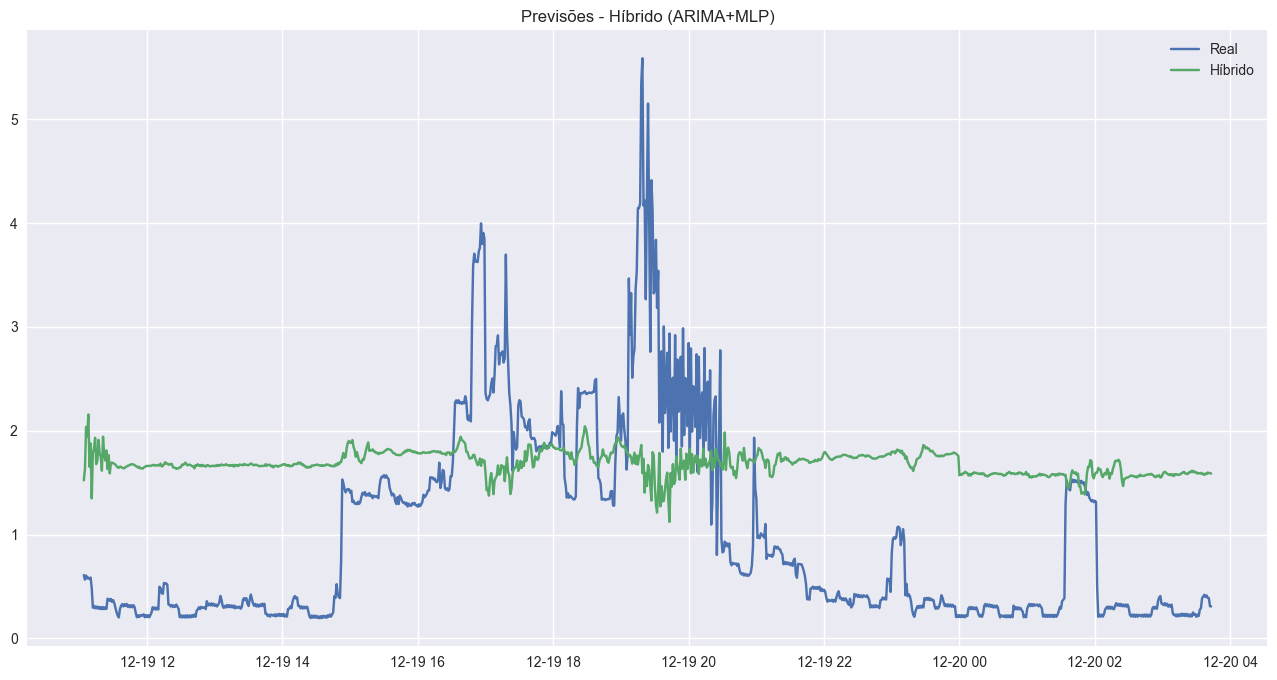

In [35]:
# Métricas e plots
y_test_aligned = y_test.reindex(y_pred_hybrid.index)
mse=mean_squared_error(y_test_aligned, y_pred_hybrid)
rmse=np.sqrt(mse)
mae=mean_absolute_error(y_test_aligned, y_pred_hybrid)
mape=np.mean(np.abs((y_test_aligned - y_pred_hybrid)/y_test_aligned))*100
r2=r2_score(y_test_aligned, y_pred_hybrid)
print('RMSE:',rmse,'MAE:',mae,'MAPE:',mape,'R2:',r2)

json.dump({'model':'Hibrido(ARIMA+MLP)','arima_order':best_order,'mlp_params':grid.best_params_,
           'metrics':{'mse':float(mse),'rmse':float(rmse),'mae':float(mae),'mape':float(mape),'r2':float(r2)}},
          open(f'{output_dir}/hybrid_results.json','w'), indent=2)
pd.DataFrame({'real':y_test_aligned, 'pred':y_pred_hybrid}).to_csv(f'{output_dir}/hybrid_predictions.csv')

plt.figure(figsize=(16,8))
plt.plot(y_test_aligned.index, y_test_aligned, label='Real')
plt.plot(y_test_aligned.index, y_pred_hybrid, label='Híbrido')
plt.legend(); plt.title('Previsões - Híbrido (ARIMA+MLP)')
plt.savefig(f'{output_dir}/hybrid_predictions.png', dpi=300)
plt.show()